<a href="https://colab.research.google.com/github/KishenPatel97/TextClustering/blob/main/Final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries and Dataset

In [1]:
!pip install matplotlib==3.4.3

!pip install datasets
!pip install spacy
!pip install nltk
!pip install ipywidgets

  Using cached matplotlib-3.4.3-cp38-cp38-win_amd64.whl (7.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\dev\\repos\\CSCE5380\\K1\\env\\Lib\\site-packages\\~atplotlib\\backends\\_backend_agg.cp38-win_amd64.pyd'
Check the permissions.



In [2]:
from datasets import load_dataset
import spacy

from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import pandas as pd
import nltk
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# download stories from here
# https://cs.nyu.edu/~kcho/DMQA/

# 114 out of over 300,000 stories are missing text

# makes datafiles from this code
# https://github.com/becxer/cnn-dailymail/blob/master/make_datafiles.py

In [4]:
# """Load the dataset using huggingface data_loader"""
# type this command in the command line for the venv for this cell to work
# jupyter nbextension enable --py widgetsnbextension --sys-prefix 
dataset = load_dataset('cnn_dailymail', '3.0.0')

Reusing dataset cnn_dailymail (C:\Users\mqxadmin\.cache\huggingface\datasets\cnn_dailymail\3.0.0\3.0.0\3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [6]:
len(dataset["train"][0]["article"])
len(dataset["test"][0]["article"])

2772

In [7]:
#print(dataset["train"][0]["article"])
print(dataset["test"][0]["article"])

(CNN)James Best, best known for his portrayal of bumbling sheriff Rosco P. Coltrane on TV's "The Dukes of Hazzard," died Monday after a brief illness. He was 88. Best died in hospice in Hickory, North Carolina, of complications from pneumonia, said Steve Latshaw, a longtime friend and Hollywood colleague. Although he'd been a busy actor for decades in theater and in Hollywood, Best didn't become famous until 1979, when "The Dukes of Hazzard's" cornpone charms began beaming into millions of American homes almost every Friday night. For seven seasons, Best's Rosco P. Coltrane chased the moonshine-running Duke boys back and forth across the back roads of fictitious Hazzard County, Georgia, although his "hot pursuit" usually ended with him crashing his patrol car. Although Rosco was slow-witted and corrupt, Best gave him a childlike enthusiasm that got laughs and made him endearing. His character became known for his distinctive "kew-kew-kew" chuckle and for goofy catchphrases such as "cuf

In [8]:
#print(dataset["train"][0]["highlights"])
print(dataset["test"][0]["highlights"])

James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88 .
"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV .


In [9]:
#print(dataset["train"][0]["id"])
print(dataset["test"][0]["id"])

00200e794fa41d3f7ce92cbf43e9fd4cd652bb09


# Data Analysis

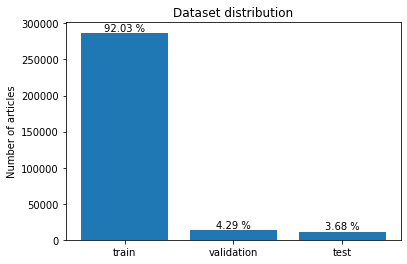

In [10]:
import matplotlib.pyplot as plt
import numpy as np

distrib = [dataset['train'].num_rows, dataset['validation'].num_rows, dataset['test'].num_rows]
sums = 0
for a in distrib:
    sums += a 

fig, ax = plt.subplots()
ind = np.arange(3)
p1 = ax.bar(ind, distrib)
ax.set_ylabel('Number of articles')
ax.set_title('Dataset distribution')
ax.set_xticks(ind)
ax.set_xticklabels(('train', 'validation', 'test'))
ax.bar_label(p1, labels=[str(round(a*100/sums,2))+' %' for a in distrib])
plt.show()

In [11]:
train_lens = []
validate_lens = []
test_lens = []

for doc in dataset['train']:
    train_lens.append(len(doc['article'].split()))

for doc in dataset['validation']:
    validate_lens.append(len(doc['article'].split()))

for doc in dataset['test']:
    test_lens.append(len(doc['article'].split()))


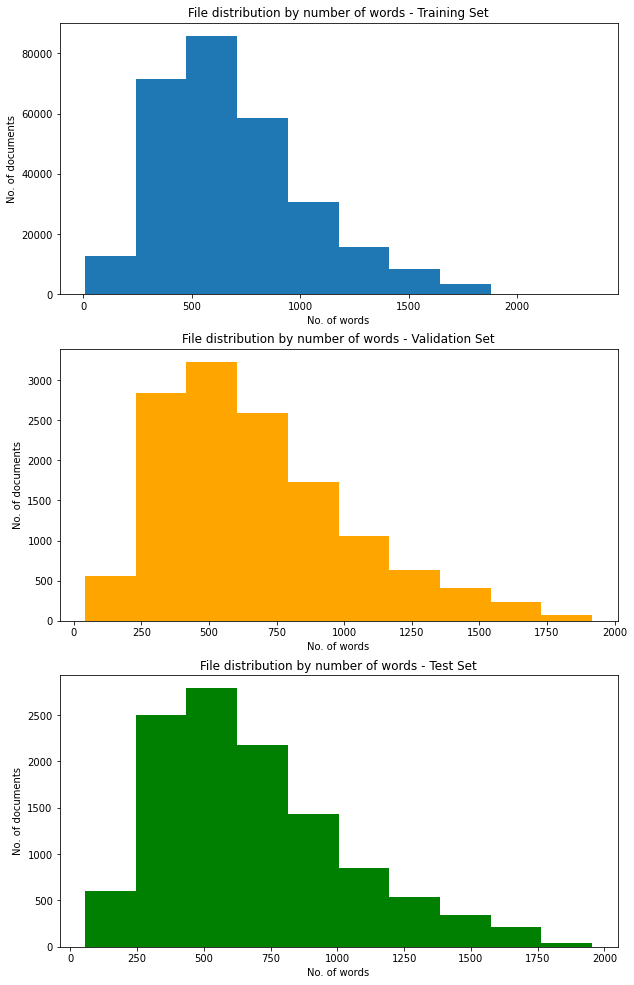

In [12]:
fig, ax2 = plt.subplots(3,1, figsize=(10,17))

ax2[0].hist(train_lens)
ax2[0].set_title('File distribution by number of words - Training Set')
ax2[0].set_xlabel('No. of words')
ax2[0].set_ylabel('No. of documents')
ax2[1].hist(validate_lens, color='orange')
ax2[1].set_title('File distribution by number of words - Validation Set')
ax2[1].set_xlabel('No. of words')
ax2[1].set_ylabel('No. of documents')
ax2[2].hist(test_lens, color='green')
ax2[2].set_title('File distribution by number of words - Test Set')
ax2[2].set_xlabel('No. of words')
ax2[2].set_ylabel('No. of documents')
plt.show()

The distribution plots above show that the dataset has maintained its distribution based on the number of words for the validation set and test set....[continue]

In [13]:
# words frequency calculation?

# Data preperation

In [14]:
punctuation_signs = list("?:!,;'")

# change to pandas df to run quicker
train_df = pd.DataFrame(dataset['test'])

# removing special characters
#train_df['article'] = train_df['article'].str.replace("\r", " ")
#train_df['article'] = train_df['article'].str.replace("\n", " ")
train_df['article'] = train_df['article'].str.replace("    ", " ")

# lowercasing text
train_df['article'] = train_df['article'].str.lower()

# removing punctuation
#for punct_sign in punctuation_signs:
#    train_df['article'] = train_df['article'].str.replace(punct_sign, '')

# remove possesive pronouns
#train_df['article'] = train_df['article'].str.replace("'s", '')
test_df = train_df.copy()

# change to pandas df to run quicker
train_df = pd.DataFrame(dataset['train'])

# removing special characters
#train_df['article'] = train_df['article'].str.replace("\r", " ")
#train_df['article'] = train_df['article'].str.replace("\n", " ")
train_df['article'] = train_df['article'].str.replace("    ", " ")

# lowercasing text
train_df['article'] = train_df['article'].str.lower()

# removing punctuation
#for punct_sign in punctuation_signs:
#    train_df['article'] = train_df['article'].str.replace(punct_sign, '')

# remove possesive pronouns
#train_df['article'] = train_df['article'].str.replace("'s", '')


In [15]:
# Original text
dataset['test'][0]['article'][:500]

'(CNN)James Best, best known for his portrayal of bumbling sheriff Rosco P. Coltrane on TV\'s "The Dukes of Hazzard," died Monday after a brief illness. He was 88. Best died in hospice in Hickory, North Carolina, of complications from pneumonia, said Steve Latshaw, a longtime friend and Hollywood colleague. Although he\'d been a busy actor for decades in theater and in Hollywood, Best didn\'t become famous until 1979, when "The Dukes of Hazzard\'s" cornpone charms began beaming into millions of Ameri'

In [16]:
# Cleaned text
test_df['article'][0][:500]

'(cnn)james best, best known for his portrayal of bumbling sheriff rosco p. coltrane on tv\'s "the dukes of hazzard," died monday after a brief illness. he was 88. best died in hospice in hickory, north carolina, of complications from pneumonia, said steve latshaw, a longtime friend and hollywood colleague. although he\'d been a busy actor for decades in theater and in hollywood, best didn\'t become famous until 1979, when "the dukes of hazzard\'s" cornpone charms began beaming into millions of ameri'

In [17]:
#!pip install spacy
import spacy, nltk
from collections import Counter
from string import punctuation

In [18]:
# Download Stanza LM
#!spacy download en_core_web_lg

In [19]:
# Initialize Spacy model
import en_core_web_lg
nlp = en_core_web_lg.load()

In [20]:
test_df['article'].head()

0    (cnn)james best, best known for his portrayal ...
1    (cnn)the attorney for a suburban new york card...
2    (cnn)president barack obama took part in a rou...
3    moscow (cnn)a russian tv channel aired hillary...
4    (cnn)marco rubio is all in.  the republican se...
Name: article, dtype: object

In [21]:
# Initialize Stanza object from yext
#doc = nlp(train_df['article'][0])
#print(doc)
doc = nlp(test_df['article'][0])
print(doc)

(cnn)james best, best known for his portrayal of bumbling sheriff rosco p. coltrane on tv's "the dukes of hazzard," died monday after a brief illness. he was 88. best died in hospice in hickory, north carolina, of complications from pneumonia, said steve latshaw, a longtime friend and hollywood colleague. although he'd been a busy actor for decades in theater and in hollywood, best didn't become famous until 1979, when "the dukes of hazzard's" cornpone charms began beaming into millions of american homes almost every friday night. for seven seasons, best's rosco p. coltrane chased the moonshine-running duke boys back and forth across the back roads of fictitious hazzard county, georgia, although his "hot pursuit" usually ended with him crashing his patrol car. although rosco was slow-witted and corrupt, best gave him a childlike enthusiasm that got laughs and made him endearing. his character became known for his distinctive "kew-kew-kew" chuckle and for goofy catchphrases such as "cuf

In [22]:
def top_sentence(text, limit=3):
    keyword = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
    doc = nlp(text.lower())
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            keyword.append(token.text)
    
    freq_word = Counter(keyword)
    max_freq = Counter(keyword).most_common(1)[0][1]
    for w in freq_word:
        freq_word[w] = (freq_word[w]/max_freq)
        
    sent_strength={}
    for sent in doc.sents:
        for word in sent:
            if word.text in freq_word.keys():
                if sent in sent_strength.keys():
                    sent_strength[sent]+=freq_word[word.text]
                else:
                    sent_strength[sent]=freq_word[word.text]
    
    summary = []
    
    sorted_x = sorted(sent_strength.items(), key=lambda kv: kv[1], reverse=True)
    
    counter = 0
    for i in range(len(sorted_x)):
        summary.append(str(sorted_x[i][0]).capitalize())

        counter += 1
        if(counter >= limit):
            break
            
    return ' '.join(summary)

In [23]:
from tqdm.notebook import tqdm
summarized = []
df = test_df
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    #print(row['article'])
    summarized.append(top_sentence(row['article'], 3))
test_summarized = summarized.copy()


  0%|          | 0/11490 [00:00<?, ?it/s]

In [24]:
test_summarized

['For seven seasons, best\'s rosco p. coltrane chased the moonshine-running duke boys back and forth across the back roads of fictitious hazzard county, georgia, although his "hot pursuit" usually ended with him crashing his patrol car. Although he\'d been a busy actor for decades in theater and in hollywood, best didn\'t become famous until 1979, when "the dukes of hazzard\'s" cornpone charms began beaming into millions of american homes almost every friday night. Among the most popular shows on tv in the early \'80s, "the dukes of hazzard" ran until 1985 and spawned tv movies, an animated series and video games.',
 'Appearing saturday morning on cnn\'s "new day," randy zelin defended his client, dr. anthony moschetto, who faces criminal solicitation, conspiracy, burglary, arson, criminal prescription sale and weapons charges in connection to what prosecutors called a plot to take out a rival doctor on long island. "he was willing to pay $5,000 to have him beaten and put in a hospital

In [25]:
top_sentence(test_df['article'][0], 3)

'For seven seasons, best\'s rosco p. coltrane chased the moonshine-running duke boys back and forth across the back roads of fictitious hazzard county, georgia, although his "hot pursuit" usually ended with him crashing his patrol car. Although he\'d been a busy actor for decades in theater and in hollywood, best didn\'t become famous until 1979, when "the dukes of hazzard\'s" cornpone charms began beaming into millions of american homes almost every friday night. Among the most popular shows on tv in the early \'80s, "the dukes of hazzard" ran until 1985 and spawned tv movies, an animated series and video games.'

In [26]:
test_df['article'][0]

'(cnn)james best, best known for his portrayal of bumbling sheriff rosco p. coltrane on tv\'s "the dukes of hazzard," died monday after a brief illness. he was 88. best died in hospice in hickory, north carolina, of complications from pneumonia, said steve latshaw, a longtime friend and hollywood colleague. although he\'d been a busy actor for decades in theater and in hollywood, best didn\'t become famous until 1979, when "the dukes of hazzard\'s" cornpone charms began beaming into millions of american homes almost every friday night. for seven seasons, best\'s rosco p. coltrane chased the moonshine-running duke boys back and forth across the back roads of fictitious hazzard county, georgia, although his "hot pursuit" usually ended with him crashing his patrol car. although rosco was slow-witted and corrupt, best gave him a childlike enthusiasm that got laughs and made him endearing. his character became known for his distinctive "kew-kew-kew" chuckle and for goofy catchphrases such a

In [27]:
test_df['highlights'][0]

'James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88 .\n"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV .'

# Model Evaluations

ROUGE for summaries

In [28]:
!pip install rouge
from rouge import Rouge

rouge = Rouge()

In [29]:
scores = rouge.get_scores(test_df['article'][0], test_df['highlights'][0])

# To extract the Score's from the ROUGE-1 Unigram method
print(scores[0]['rouge-1'])

# To extract the score's from the ROUGE-2 Bigram method
print(scores[0]['rouge-2'])

# To extract the score's from the ROUGE-L Longest Common Sequence method
print(scores[0]['rouge-l'])

# 'r' = Recall
# 'p' = precision
# 'f' = F1-score
scores = rouge.get_scores(test_df['article'][0], test_summarized[0])

# To extract the Score's from the ROUGE-1 Unigram method
print(scores[0]['rouge-1'])

# To extract the score's from the ROUGE-2 Bigram method
print(scores[0]['rouge-2'])

# To extract the score's from the ROUGE-L Longest Common Sequence method
print(scores[0]['rouge-l'])

# 'r' = Recall
# 'p' = precision
# 'f' = F1-score

{'r': 0.6785714285714286, 'p': 0.06209150326797386, 'f': 0.11377245355373088}
{'r': 0.27586206896551724, 'p': 0.017817371937639197, 'f': 0.0334728022075069}
{'r': 0.5714285714285714, 'p': 0.05228758169934641, 'f': 0.09580838169744345}
{'r': 0.9642857142857143, 'p': 0.2647058823529412, 'f': 0.4153846120047337}
{'r': 0.9489795918367347, 'p': 0.2071269487750557, 'f': 0.3400365601300763}
{'r': 0.9642857142857143, 'p': 0.2647058823529412, 'f': 0.4153846120047337}


In [30]:
rouge1_f1scores = []
rouge1_pscores = []
rouge1_rscores = []
rouge2_f1scores = []
rouge2_pscores = []
rouge2_rscores = []
rougel_f1scores = []
rougel_pscores = []
rougel_rscores = []
for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
  scores = rouge.get_scores(test_summarized[index], test_df['highlights'][index] )
  rouge1_f1scores.append(scores[0]['rouge-1']['f'])
  rouge1_pscores.append(scores[0]['rouge-1']['p'])
  rouge1_rscores.append(scores[0]['rouge-1']['r'])
  rouge2_f1scores.append(scores[0]['rouge-2']['f'])
  rouge2_pscores.append(scores[0]['rouge-2']['p'])
  rouge2_rscores.append(scores[0]['rouge-2']['r'])
  rougel_f1scores.append(scores[0]['rouge-l']['f'])
  rougel_pscores.append(scores[0]['rouge-l']['p'])
  rougel_rscores.append(scores[0]['rouge-l']['r'])


  0%|          | 0/11490 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Rougel Recall')

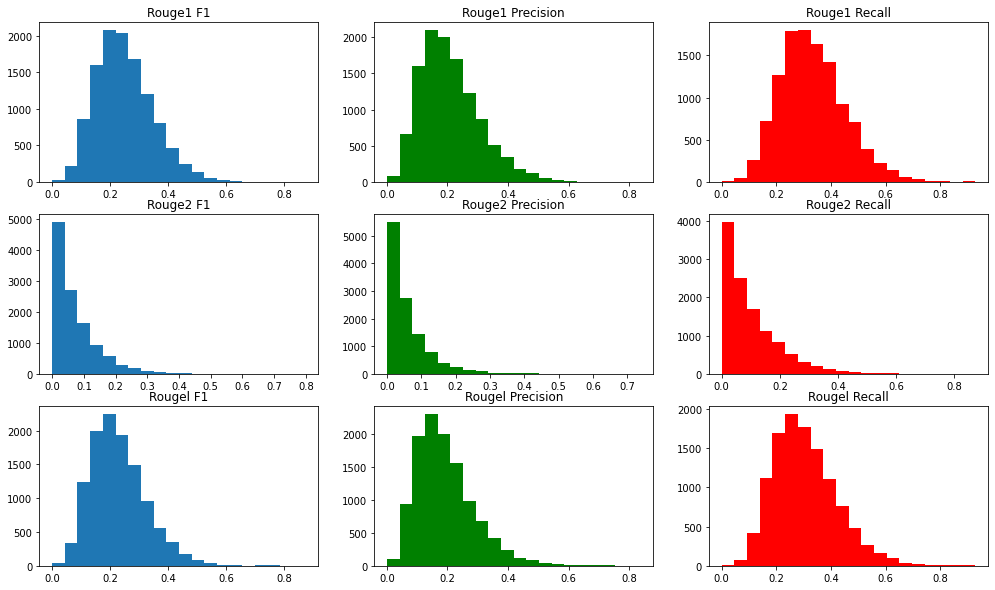

In [31]:
fig, ax = plt.subplots(3,3, figsize=(17,10))
ax[0,0].hist(rouge1_f1scores, 20)
ax[0,0].set_title('Rouge1 F1')
ax[0,1].hist(rouge1_pscores, 20, color='g')
ax[0,1].set_title('Rouge1 Precision')
ax[0,2].hist(rouge1_rscores, 20, color='r')
ax[0,2].set_title('Rouge1 Recall')
ax[1,0].hist(rouge2_f1scores, 20)
ax[1,0].set_title('Rouge2 F1')
ax[1,1].hist(rouge2_pscores, 20, color='g')
ax[1,1].set_title('Rouge2 Precision')
ax[1,2].hist(rouge2_rscores, 20, color='r')
ax[1,2].set_title('Rouge2 Recall')
ax[2,0].hist(rougel_f1scores, 20)
ax[2,0].set_title('Rougel F1')
ax[2,1].hist(rougel_pscores, 20, color='g')
ax[2,1].set_title('Rougel Precision')
ax[2,2].hist(rougel_rscores, 20, color='r')
ax[2,2].set_title('Rougel Recall')

In [32]:
#print(test_df['highlights'].values.tolist()[0])
#print(test_summarized[0])
#hyps, refs = zip(test_summarized,test_df['highlights'].items())
#print(type(hyps), type(refs))

scores = rouge.get_scores(test_summarized, test_df['highlights'].values.tolist(), avg=True)

# 'r' = Recall
# 'p' = precision
# 'f' = F1-score
print(scores)

{'rouge-1': {'r': 0.33268055568795546, 'p': 0.21054174379799875, 'f': 0.2496251043155539}, 'rouge-2': {'r': 0.10095390416674065, 'p': 0.059817371192646074, 'f': 0.07211029134732368}, 'rouge-l': {'r': 0.30525157906172573, 'p': 0.19320084265767384, 'f': 0.22903496282486482}}


In [33]:
rouge1_f1scores = []
rouge1_pscores = []
rouge1_rscores = []
rouge2_f1scores = []
rouge2_pscores = []
rouge2_rscores = []
rougel_f1scores = []
rougel_pscores = []
rougel_rscores = []
for summary, highlight in tqdm(zip(open("test.jsonl.hyps", "r").readlines(), open("test.jsonl.refs", "r").readlines())):
  scores = rouge.get_scores(summary, highlight )
  rouge1_f1scores.append(scores[0]['rouge-1']['f'])
  rouge1_pscores.append(scores[0]['rouge-1']['p'])
  rouge1_rscores.append(scores[0]['rouge-1']['r'])
  rouge2_f1scores.append(scores[0]['rouge-2']['f'])
  rouge2_pscores.append(scores[0]['rouge-2']['p'])
  rouge2_rscores.append(scores[0]['rouge-2']['r'])
  rougel_f1scores.append(scores[0]['rouge-l']['f'])
  rougel_pscores.append(scores[0]['rouge-l']['p'])
  rougel_rscores.append(scores[0]['rouge-l']['r'])


0it [00:00, ?it/s]

Text(0.5, 1.0, 'Rougel Recall')

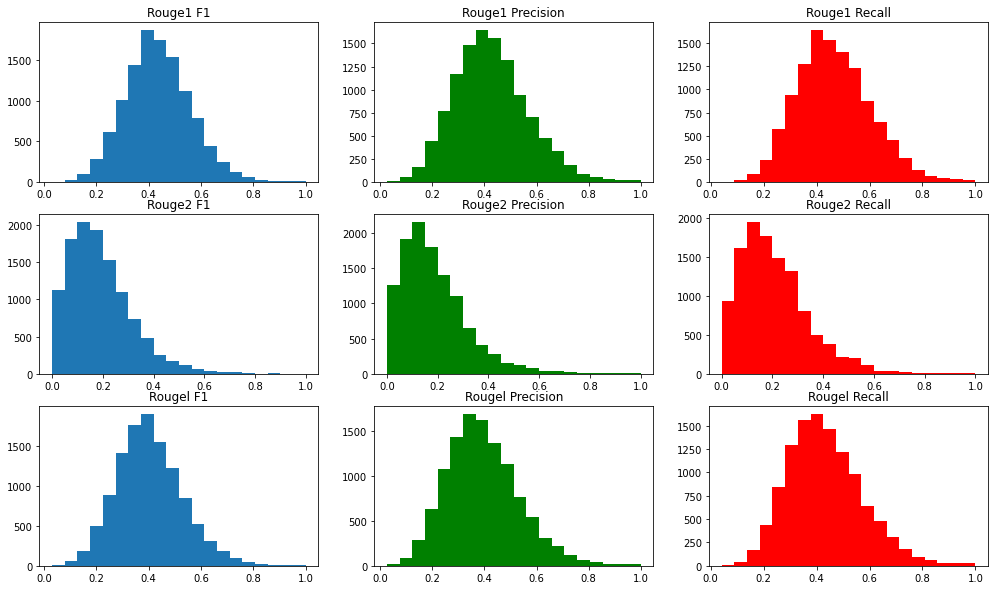

In [34]:
fig, ax = plt.subplots(3,3, figsize=(17,10))
ax[0,0].hist(rouge1_f1scores, 20)
ax[0,0].set_title('Rouge1 F1')
ax[0,1].hist(rouge1_pscores, 20, color='g')
ax[0,1].set_title('Rouge1 Precision')
ax[0,2].hist(rouge1_rscores, 20, color='r')
ax[0,2].set_title('Rouge1 Recall')
ax[1,0].hist(rouge2_f1scores, 20)
ax[1,0].set_title('Rouge2 F1')
ax[1,1].hist(rouge2_pscores, 20, color='g')
ax[1,1].set_title('Rouge2 Precision')
ax[1,2].hist(rouge2_rscores, 20, color='r')
ax[1,2].set_title('Rouge2 Recall')
ax[2,0].hist(rougel_f1scores, 20)
ax[2,0].set_title('Rougel F1')
ax[2,1].hist(rougel_pscores, 20, color='g')
ax[2,1].set_title('Rougel Precision')
ax[2,2].hist(rougel_rscores, 20, color='r')
ax[2,2].set_title('Rougel Recall')

In [35]:
scores = rouge.get_scores(open("test.jsonl.hyps", "r").readlines() , open("test.jsonl.refs", "r").readlines() , avg=True)
print(scores)

{'rouge-1': {'r': 0.4666097414612412, 'p': 0.4269661592665677, 'f': 0.43639777291042925}, 'rouge-2': {'r': 0.20852076878634515, 'p': 0.18735132827182935, 'f': 0.19155053415895684}, 'rouge-l': {'r': 0.43251439988807816, 'p': 0.3956479422878399, 'f': 0.40445999482404615}}
